# "Photometry FLMM Guide Part I : Data Formating and Binary Variables"
## Authors: Gabriel Loewinger, Erjia Cui
### rpy2 implementation: Josh Lawrimore

## Introduction

`fastFMM` is a fast toolkit for fitting Functional Linear Mixed Models (FLMM). Instead of analyzing summary measures of photometry signals (e.g., Area-Under-the-Curve, peak amplitude), FLMM allows you to analyze the relationship between photometry signals and experimental/behavioral variables (e.g., CS+/CS-, total presses, treatment/control groups) at each time-point of the trial. Therefore, FLMM provides a unique opportunity to reveal potentially time-varying signal changes that are obscured by analyzing only summary measures (e.g., see [Loewinger et al. (2024)](https://elifesciences.org/reviewed-preprints/95802)). Although our package can fit the wider class of generalized functional mixed models, this guide focuses on FLMM. 


## Installation

Please see `R and rpy2 installation guide.ipynb` for fast_fmm_rpy2 package instructions.

## Package Installation for Python

This tutorial `pandas` to read in the data into Python and `rpy2` to pass the data in Python to the fastFMM model in R.

In [1]:
#check the installation for rpy2
import rpy2.situation
print(rpy2.situation.r_home_from_subprocess())

/usr/lib/R


In [10]:
%load_ext rpy2.ipython
import os
# Set R_HOME environment variable before importing rpy2
# os.environ['R_HOME'] = '/usr/lib/R'

from fast_fmm_rpy2.ingest import read_csv_in_pandas_pass_to_r
from fast_fmm_rpy2.fmm_run import fui
from fast_fmm_rpy2.plot_fui import plot_fui
from matplotlib import pyplot as plt
from pathlib import Path


# Tutorial Guide

We start by analyzing trial-level photometry signals (each trial is a 5 second $\Delta F/ F$ signal) collected from multiple animals, on multiple sessions (each of which contains multiple trials). You can pre-process your data in any programming language you like, but it is recommended to save the processed dataset as a CSV file to then read into Python using Pandas.

## Data Formating

For demonstration purpose, we have pre-processed a dataset stored as `binary.csv`. This data was taken from Test 4 of [Jeong et al., 2022](https://www.science.org/doi/full/10.1126/science.abq6740) and we thank the authors for generously making their data public and helping us analyze it.

Let's load the data and take a look at its structure of the first several columns. Please make sure to either set your working directory in R first using `setwd()` function, or specify the file pathname in the `read.csv('path/to/file/photometry_data.csv')`. 

Below we will load the data using Pandas and then pass the DataFrame to R using robjects.

In [3]:
dat = read_csv_in_pandas_pass_to_r(Path(r"./binary.csv"), r_var_name="py_dat")
dat.iloc[:6, :10].round(6)


,id,session,trial,cs,photometry.1,photometry.2,photometry.3,photometry.4,photometry.5,photometry.6
1,3,1,1,0,-0.809812,-0.626058,-0.483961,-0.413546,-0.336471,-0.335356
2,3,1,2,0,-0.036672,-0.136334,0.004629,-0.022377,0.028563,0.251319
3,3,1,3,0,-0.240734,-0.058142,0.037320,-0.074751,-0.241963,-0.275894
4,3,1,4,0,0.058436,0.031882,-0.041083,0.079589,0.062124,-0.047202
5,3,1,5,0,-0.133563,0.023707,0.017429,-0.128284,-0.107942,-0.086204
6,3,1,6,0,-0.547296,-0.546651,-0.443568,-0.380148,-0.308948,-0.329261


The dataset pools trials across animals, and sessions. Each row is a single trial and contains both experimental information and the values of the photometry signal at each of 125 trial timepoints. The first 4 columns of this dataset include the subject ID (${id}$), session number (${session}$), trial number (${trial}$), and cue type CS+/CS- (${cs}$). Since the first 6 trials in the dataset are all from animal 3 on session 1, the values of the ${id}$ and ${session}$ entry are the same for these rows. If we looked further down in the dataset, we would see other values in the ${id}$ and ${session}$ columns. Note that the actual ordering of these first four columns does not matter, that is, it is not necessary to reorder the data for the analysis. The column ${cs}$ is a covariate of interest and indicates whether the trial was a CS+ trial ($cs = 0$), or a CS- trial ($cs = 1$). The remaining columns contain the photometry signal values (e.g., $\Delta F / F$). We have 125 photometry values stored in columns ${photometry.1}$, ${photometry.2}$, ..., ${photometry.125}$ because the trials are 5 seconds long and the signal was downsampled to 25 Hz. 

With such data structures, we can specify an FLMM using the `fui()` function. The function assumes that whatever character string used to label the columns for the photometry signal preceeding the "." only occurs in columns corresponding to the signal. For example, if we specified a model `fui(photometry ~ cue + (1 | id), ...`, then all columns starting with 'photometry.', will be interpreted as the photometry signal (here we use ${photometry.}$, but we could have used anything else, such as ${Y.}$). For that reason we recommend not naming other variables in your dataset using names that contain the same characters as the response(e.g., ${photometryAUC}$). Similarly, please do not name other variables with a period '.'. A safe variable name could be ${photo\_AUC}$ to avoid any issues with the analysis code.

Alternatively, instead of relying on the column names, we can save the $N \times L$ matrix associated with our photometry signals as a variable of a dataframe using the `I()` function. The `fui()` function accepts either format style.

## Model Fitting and Function Arguments

The `fui()` function syntax begins with the functional outcome ${photometry}$ followed by $\sim$, then the fixed-effect covariates (here we only have binary one: ${cs}$), and the random effects inside the parentheses: (e.g., ${(1 | id)}$). The motivation of including random effects is to model the variability of photometry signal profiles across animals and to model the dependence arising $across$ trials within the same animals. To the left of the ${|}$ are the covariates included for random-effects (here a ${1}$ means only a random intercept is included. But if we wanted a random-slope for ${cs}$, we would write $({cs | id})$. To the right of the ${|}$ indicates the cluster or grouping variable. For us, this will usually be animal ${id}$. We specify the name of our data object in ${R}$, which we have just called `dat`. The syntax is based off of the `lmer()` function in the `lme4` package. Finally, we set `parallel = TRUE` to parallelize the function. This often substantially speeds up the code. It is not necessary though, and will not influence the model fit.

Let's explore a few simple questions to understand how we might go about conducting FLMM analyses similar to common analyses like t-tests, correlations, repeated-measures ANOVAs, etc.

## Binary covariate: Akin to FLMM version of a paired t-test: 

We begin by analyzing data from a Pavlovian task in which a reward-predictive CS+ and a CS- (not predictive of reward). We can compare the mean differences between CS+/CS- in photometry signal magnitude at each trial timepoint. This is akin to 1) taking an average trace for CS+ trials, 2) calculating an average trace for CS- trials, 3) taking the difference (at each timepoint) between the two average traces, and 3) examining where the difference in the average trace is significantly different than 0 (i.e., trial timepoints on CS+ trials in which the mean dF/F was significantly different than the mean dF/F at those timepoints on CS- trials).

Let's start with a simple model, which can be viewed as the functional version of a paired t-test: we fit models with the binary ${cs}$ covariate as the only predictor. This gives us a trial timepoint-by-timepoint test of whether there are significant differences in the photometry signal between CS+ and CS- trials. The figure output will show whether the mean signal was significantly higher/lower on CS+ trials than on CS- trials at trial timepoint 1, 2, 3, etc.

After specifying the rules for how to pass float values into R, we can fit a model and plot the output. Pretty easy, right?

In [16]:
def r2py(mod):
    d = dict(zip(mod.names(), list(mod)))
    return d

def fui2(**kwargs):
    m = fui(**kwargs)
    return r2py(m)

R callback write-console: Number of cores used for parallelization: 21
  


[1] "Step 1: Fit Massively Univariate Mixed Models"
[1] "Step 2: Smoothing"
[1] "Step 3: Inference (Analytic)"
[1] "Step 3.1: Preparation"
[1] "Step 3.1.1: Method of Moments Covariance Estimator Random Intercept"
[1] "Step 3.1.2: Smooth G"
[1] "Step 3.2: First step"
[1] "Step 3.2.1: First step"
[1] "Step 3.3: Second step"


R callback write-console: Complete!
 - Use plot_fui() function to plot estimates.
 - For more information, run the command:  ?plot_fui
  


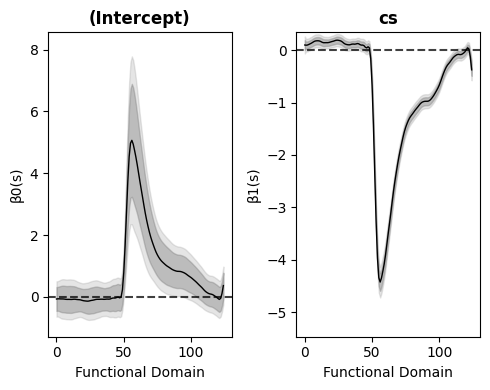

In [17]:
mod = fui2(csv_filepath=Path(r"./binary.csv"), formula="photometry ~ cs + (1 | id)", parallel=True)
figure = plot_fui(mod)


Typically, we will want to compare a number of models that compare CS+ trials (${cs}=0$) to CS- trials (${cs}=1$) before inspecting the results. By comparing models with different random effect specifications (that may capture different dependence structures across trials, and heterogeneity patterns across animals), we can identify which one yields a superior fit (based on AIC, BIC or other metrics), and hopefully captures trends in the data and quantify uncertainty better.

Let's go through a simple example. Let's fit one model with an animal-specific random intercept, and a second model with both an animal-specific random intercept and random slope. 

Model 1:
$$
\begin{aligned} 
& \mathbb{E}[Y_{ij}(s) \mid X_{ij}, \boldsymbol{\gamma}_i(s)] =  \beta_0(s) + {X}_{ij}{\beta}_1(s) + {\gamma}_{0,i}(s)  \notag 
\end{aligned} 
$$ 
Model 2:
$$
\begin{aligned} 
& \mathbb{E}[Y_{ij}(s) \mid X_{ij}, \boldsymbol{\gamma}_i(s)] =  \beta_0(s) + {\gamma}_{0,i}(s) + {X}_{ij}\left[{\beta}_1(s) + {\gamma}_{1,i}(s) \right ] \notag 
\end{aligned} 
$$ 

In [18]:
# fit two models
mod1 = fui2(csv_filepath=Path(r"./binary.csv"), formula="photometry ~ cs + (1 | id)", parallel=True) # random intercept model
mod2 = fui2(csv_filepath=Path(r"./binary.csv"), formula="photometry ~ cs + (cs | id)", parallel=False) # random intercept model


R callback write-console: Number of cores used for parallelization: 21
  


[1] "Step 1: Fit Massively Univariate Mixed Models"
[1] "Step 2: Smoothing"
[1] "Step 3: Inference (Analytic)"
[1] "Step 3.1: Preparation"
[1] "Step 3.1.1: Method of Moments Covariance Estimator Random Intercept"
[1] "Step 3.1.2: Smooth G"
[1] "Step 3.2: First step"
[1] "Step 3.2.1: First step"
[1] "Step 3.3: Second step"


R callback write-console: Complete!
 - Use plot_fui() function to plot estimates.
 - For more information, run the command:  ?plot_fui
  


[1] "Step 1: Fit Massively Univariate Mixed Models"
[1] "Step 2: Smoothing"
[1] "Step 3: Inference (Analytic)"
[1] "Step 3.1: Preparation"
[1] "Step 3.1.1: Preparation B"
[1] "Step 3.1.1: Method of Moments Covariance Estimator"
[1] "Step 3.1.2: Smooth G"
[1] "Step 3.2: First step"
[1] "Step 3.2.1: First step"
[1] "Step 3.3: Second step"


R callback write-console: Complete!
 - Use plot_fui() function to plot estimates.
 - For more information, run the command:  ?plot_fui
  


To avoid biasing our model selection, let’s compare the two models’ AIC/BIC values and only inspect the output of the selected model. Below we see that model 2 (the model shown above) yields a superior fit (lower AIC and BIC values). Therefore, we will use that model for inference.

In [20]:
# average pointwise model fits
# worse model: higher AIC/BIC
mod1 = mod1
mod1['aic'].mean().round(3).to_frame().T


,AIC,BIC,cAIC
0,1588.326,1606.472,NaN


In [21]:
# superior model: lower AIC/BIC
mod2['aic'].mean().round(3).to_frame().T


,AIC,BIC,cAIC
0,1482.376,1509.596,NaN


Now that we have chosen a model, let's plot the output again but include a few extra function arguments in the `plot_fui()` to make the plots more readable. 


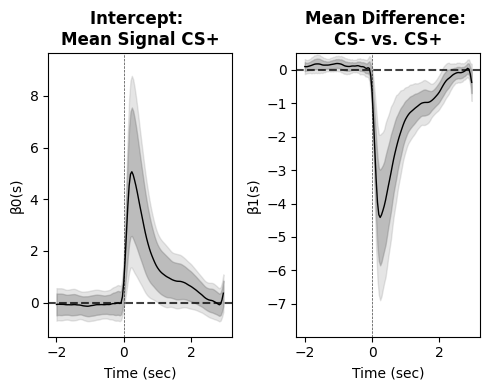

In [22]:
# plot model with best model fit (AIC/BIC)
figure, model_results = plot_fui(mod2, 
                   xlab = "Time (sec)", # label x-axis
                   x_rescale = 25, # rescale x-axis to be in sec - photometry sampled at 25 Hz 
                   align_x = 2, # align to time of cue onset
                   title_names = ("Intercept: \nMean Signal CS+", 
                                   "Mean Difference: \nCS- vs. CS+"),
                   return_data = True) # use return = TRUE to save coefficient info


The plot on the left is the functional intercept, $\beta_0(s)$. Often this is not of scientific interest but because we coded CS+ trials as $X_{ij} = 0$, and CS- as $X_{ij} = 1$, the functional intercept has the interpretation as "the mean signal on CS+ trials." We are probably more interested in $differences$ between CS+/CS- but we can see there is a statistically significant increase in the mean signal on CS+ trials for the first second after cue onset (in the interval: 0s - 1s) relative to trial baselines (the exact interpretation depends on how we normalize our signal, which we discuss later). This will yield something comparable to just taking an average trace on CS+ trials, but the advantage of this is it shows us where the signal is significantly different from 0.

The plot on the right is the estimated functional coefficient $\widehat{\beta}_1(s)$. This plot shows the difference between CS- and CS+ trials at each corresponding trial timepoint. Time intervals where the light grey confidence bands do not contain 0 indicate that there is a statistically significant difference in the mean signal magnitude on CS- trials relative to CS+ trials. Because we coded CS+ trials as $X_{ij} = 0$, and CS- as $X_{ij} = 1$, a negative coefficient estimate indicates CS+ has a greater magnitude. Thus, the plot shows a significantly higher mean signal on CS+ trials from 0 to 2 seconds after cue onset. This is conceptually similar to fitting a separate paired t-test on the photometry signal values (CS+ vs. CS-) at each trial timepoint. However, FLMM takes into account the order of the data since they were collected over time, thus providing a more reliable estimate. Moreover, the joint confidence provide a type of multiple comparisons correction for inspecting estimates at every timepoint. 

Figure 6C-D from our our paper, [Loewinger et al., 2024](https://elifesciences.org/reviewed-preprints/95802), illustrates this point, albeit using a different analysis. In this experiment, the binary variable was the length of the delay (short vs. long) between cue onset and reward instead of CS+/CS-. The intuition is, however, the same. Figure D shows how the $\widehat{\beta}_1(s)$ coefficient in a FLMM with only a binary covariate is conceptually similar to just taking the average dF/F traces for CS+ trials (or long delay trials here) and CS- (or short delay trials here) and subtracting them.


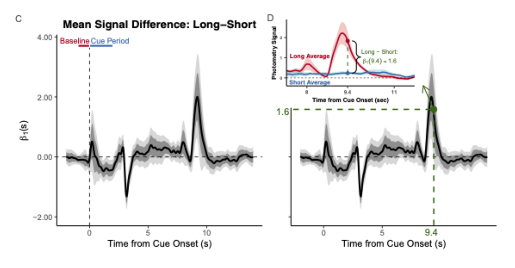

In [23]:
image = plt.imread(r"../../Figures/Figure 6/Delay Effect Inset Combined.png")
plt.axis("off")
ax = plt.imshow(image)


# Coefficient Interpretation

The rationale for the coefficient estimates interpretations above (and more generally) can be understood with a couple simple algebraic steps.

First, remember that we are modeling $\mathbb{E}[Y_{ij}(s) \mid X_{ij}, \boldsymbol{\gamma}_i(s)]$, the average photometry signal for animal $i$, on trial $j$ at trial timepoint $s$ only as a function of whether a given trial is a CS+ ($X_{ij}=0$) or a CS- ($X_{ij}=1$):

$$
\begin{aligned} 
& \mathbb{E}[Y_{ij}(s) \mid X_{ij}, \boldsymbol{\gamma}_i(s)] =  \beta_0(s) + {\gamma}_{0,i}(s) + {X}_{ij}\left[{\beta}_1(s) + {\gamma}_{1,i}(s) \right ]. \notag 
\end{aligned} 
$$ 
We find the $marginal$ interpretation appealing for our functional fixed effect coefficients in photometry experiments, so observe that the above model can also be interpreted marginally with respect to the functional random effects, $\boldsymbol{\gamma}(s)$ through the induced marginal model:

$$
\begin{aligned} 
& \mathbb{E}_{\boldsymbol{Y}}[Y_{ij}(s) \mid X_{ij}] =\mathbb{E}_{\boldsymbol{\gamma}_i}[ \mathbb{E}_{\boldsymbol{Y}}[Y_{ij}(s) \mid X_{ij}, \boldsymbol{\gamma}_i(s)] \mid X_{ij}] =  \beta_0(s) + {X}_{ij} {\beta}_1(s). \notag 
\end{aligned} 
$$ 
The above follows by recalling the model assumption that $\mathbb{E}[\boldsymbol{\gamma}_i] = \mathbb{E}[\boldsymbol{\gamma}_i \mid X_{ij}] = \boldsymbol{0}$.


## Functional Intercept Interpretation

Now the reason the functional intercept, $\beta_0(s)$, has the interpretation as the mean signal on CS+ trials is because we coded the CS variable (denoted as $X_{ij}$) to be $X_{ij} = 0$ for CS+ trials. In linear models, the intercept will have the interpretation as the mean outcome when all model covariates are equal to 0. Since we only have one covariate here (CS+/CS-), and that covariate equals 0 on CS+ trials, the model conveniently yields this interpretation. We can see this by plugging $X_{ij} = 0$ into our model, and seeing how the mean photometry signal on CS+ trials is the coefficient attained when plugging in $X_{ij} = 0$:

$$
\begin{align} 
\mathbb{E}[Y_{ij}(s) \mid X_{ij} = 0] &= \beta_0(s) + 0*{\beta}_1(s)  \\
&=\beta_0(s).
\end{align} 
$$

## Functional Slope Interpretation

The reason the functional slope, $\beta_1(s)$, has the interpretation as the mean difference between CS+ and CS- trials can be seen through a similar exercise:

$$
\begin{align} 
&\mathbb{E}[Y_{ij}(s) \mid X_{ij} = 1] - \mathbb{E}[Y_{ij}(s) \mid X_{ij} = 0] \\
&=\beta_0(s) + 1*{\beta}_1(s)  - \left [ \beta_0(s) + 0*{\beta}_1(s) \right ] \\
&=\beta_1(s).
\end{align} 
$$

Besides the notation for modeling the signal at every trial timepoint, these simple algebraic steps are essentially the same steps used in interpreting coefficients in linear regression. Remember, in FLMM models (i.e., in selecting the covariates and random effects to include), our job is to specify a model for how the signal changes across different covariate values (e.g., $across$ conditions, trials, sessions, treatment groups, etc.). The evolution of the signal $within$ a given trial (across trial timepoints) is handled implicitly by our software: it does $not$ need to be modeled explicitly in the model specification with fixed or random effects.



# Exporting Results
If you want to export the results and make figures yourself, we can adjust an argument in the `plot_fui()` to save the results and then look at the objects stored in the results. We did this above when we set `return = TRUE` and assigned the `plot_fui()` results to the ${model\_results}$ object.

The ${model\_results}$ object now contains two dataframes, one with all the data needed to construct the figure for $\widehat{\beta}_0(s)$ and one for $\widehat{\beta}_1(s)$. Each one contains the data for both joint and pointwise CIs as well as the coefficient estimates. It will have 125 rows since we have 125 datapoints in the photometry signal on each trial. Let's look at the dataframe for $\widehat{\beta}_1(s)$ (for the cue variable ${cs}$).


In [24]:
model_results['cs'].head().round(2)


,s,beta,lower,upper,lower_joint,upper_joint
1,1,0.10,-0.03,0.23,-0.13,0.33
2,2,0.10,-0.02,0.21,-0.11,0.30
3,3,0.10,-0.01,0.21,-0.10,0.29
4,4,0.11,-0.01,0.23,-0.09,0.31
5,5,0.12,0.00,0.24,-0.09,0.33


We can save this as a CSV to use for plotting in another programming language.

In [25]:
# save CSV for beta0 (Intercept)
model_results['(Intercept)'].to_csv("beta0.csv", index=False)

# save CSV for beta1 (CS+/CS- effect)
model_results['cs'].to_csv("beta1.csv", index=False)


# Pointwise or Joint 95% Confidence Intervals
We recommend basing inference off of joint CIs for two reasons: interpretability and multiple comparisons corrections. Joint CIs identify $intervals$ of the trial during which the effects are significant, while pointwise identify individual timepoints that are significant. Typically analyst are more interested in time intervals and so we argue joint CIs are more interpretable in photometry analyses. Joint CIs also provide an adjustment for the multiple comparisons of inspecting effects along the entire trial. It is reasonable to report both types of CIs, but we recommend basing conclusions off of joint CIs in most situations.

# How to Cite
For use of this package or vignette, please cite the following papers:

Gabriel Loewinger, Erjia Cui, David Lovinger, and Francisco Pereiera. [A Statistical Framework for Analysis of Trial-Level Temporal Dynamics in Fiber Photometry Experiments](https://elifesciences.org/reviewed-preprints/95802). eLife (2024).

Erjia Cui, Andrew Leroux, Ekaterina Smirnova, and Ciprian Crainiceanu. [Fast Univariate Inference for Longitudinal Functional Models](https://doi.org/10.1080/10618600.2021.1950006). Journal of Computational and Graphical Statistics (2022).

# References

Doug Bates. [lme4: Mixed-effects modeling with R](https://stat.ethz.ch/~maechler/MEMo-pages/lMMwR.pdf) (2022).

Huijeong Jeong, Annie Taylor, Joseph Floeder, Martin Lohmann, Stefan Mihalas, Brenda Wu, Mingkang Zhou, Dennis Burke, Vijay Namboodiri. [Mesolimbic dopamine release conveys causal associations.](https://www.science.org/doi/full/10.1126/science.abq6740) Science 378, 6740 (2022).